In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
from pandas import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from fbprophet import Prophet

In [75]:
from pyecharts import options as opts
from pyecharts.charts import Calendar, Bar, Line, Pie, Map, Page, ThemeRiver, Timeline, Grid, Kline, TreeMap, WordCloud, Scatter, EffectScatter
from pyecharts.components import Table
from pyecharts.options import ComponentTitleOpts
from pyecharts.commons.utils import JsCode
from pyecharts.globals import SymbolType

In [189]:
train = pd.read_csv("./data/train.csv", parse_dates = True, index_col = 'Date')
store = pd.read_csv("./data/store.csv")

In [9]:
print("In total: ", train.shape)

In total:  (1017209, 8)


In [10]:
train.head(5).append(train.tail(5))

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [196]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

In [197]:
train['SalePerCustomer'] = train['Sales']/train['Customers']

## 经验分布函数 （ECDF: empirical cumulative distribution function）

经验分布函数值表示所有观测样本中小于或等于该值的样本所占的比例。

$$\hat{F}_{n}(t)=\frac{\text { number of elements in the sample } \leq t}{n}=\frac{1}{n} \sum_{i=1}^{n} \mathbf{1}_{x_{i} \leq t}$$

可以通过画 ECDF 图来获得连续变量的大致分布。

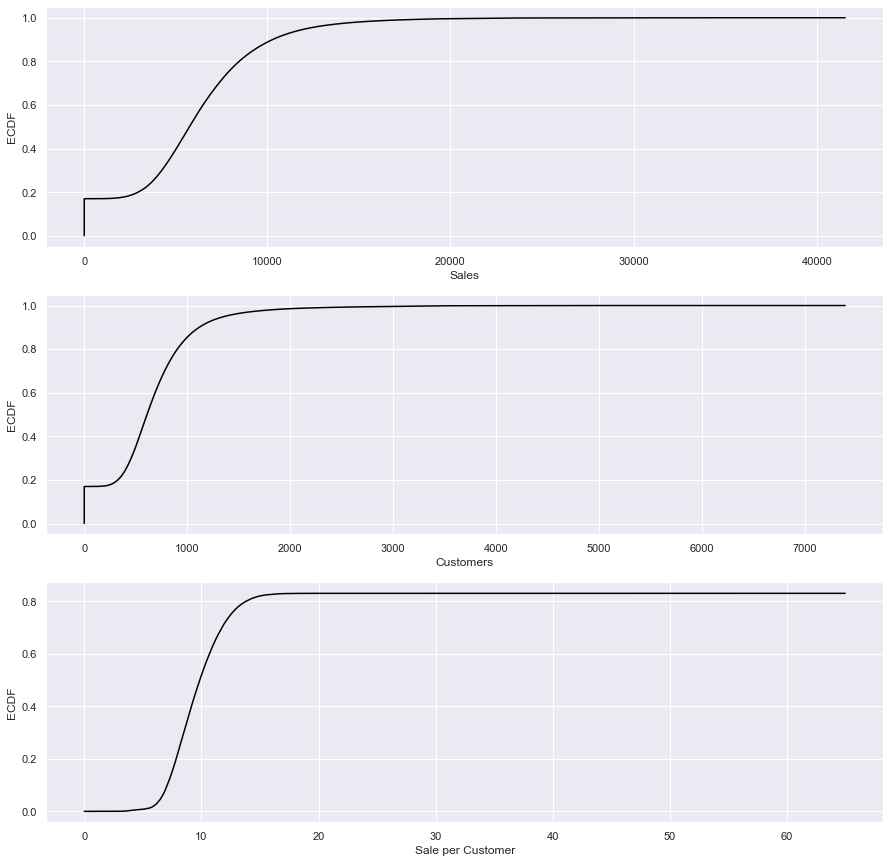

In [36]:
sns.set()
plt.figure(figsize = (15, 15))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, color = 'black');
plt.xlabel('Sales'); 
plt.ylabel('ECDF');

plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, color = 'black');
plt.xlabel('Customers');
plt.ylabel('ECDF');

plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, color = 'black');
plt.xlabel('Sale per Customer');
plt.ylabel('ECDF');

有接近20%的销售额和客户量是0，并且90%的销售额小于10000。

## 缺失值

In [37]:
train[(train.Open == 0) & (train.Sales == 0)].shape

(172817, 13)

绝大部分销售为 0 是因为商店关门，但是也有开门销售也为 0 的情况。

In [38]:
# 商店开门，但是销售为 0
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)

In total:  (54, 13)


In [40]:
zero_sales.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


总共有 54 个数据是商店开门但是销售为 0，因为这些数据要么是因为异常，要么是因为其他事件。

看看是否有商店不开门，但是销售量为 0 的情况。

In [43]:
train[(train.Open == 0) & (train.Sales != 0)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,


In [198]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


## Store

In [9]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [45]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [93]:
store[store['Promo2']==0].shape

(544, 10)

In [199]:
# 对 'Promo2SinceWeek','Promo2SinceYear','PromoInterval' 补充为 0
store.fillna({'Promo2SinceWeek':0, 'Promo2SinceYear':0,'PromoInterval':0}, inplace=True)

In [95]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Text(0.5, 1.0, 'CompetitionDistance Distribution')

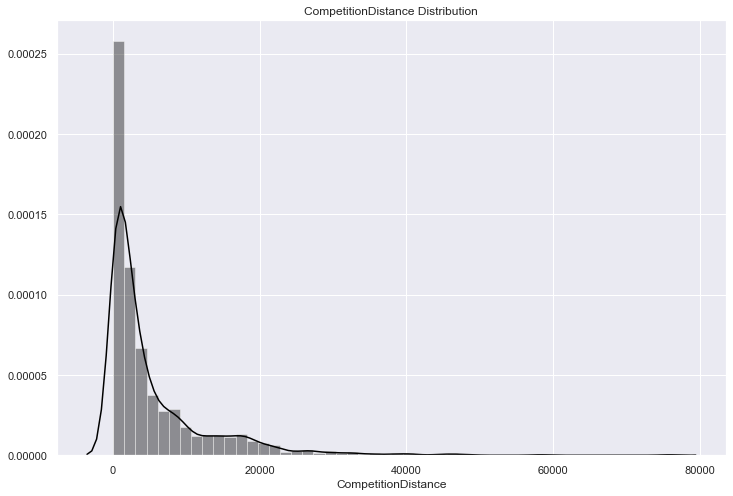

In [81]:
plt.figure(figsize=(12,8))
sns.distplot(store.CompetitionDistance,color='black')
plt.title('CompetitionDistance Distribution')

In [200]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [69]:
def bar(data, column, title) -> Bar:
    c = (
        Bar()
        .add_xaxis(list(data['index']))
        .add_yaxis("", list(data[column]))
        .set_global_opts(title_opts=opts.TitleOpts(title=title))
    )
    return c

In [70]:
CompetitionOpenSinceYear = \
    pd.DataFrame(store['CompetitionOpenSinceYear'].value_counts()).sort_index(ascending=False).reset_index()

c = bar(CompetitionOpenSinceYear,'CompetitionOpenSinceYear', "CompetitionOpenSinceYear Distribution")
c.render_notebook()

In [97]:
# 对于 CompetitionOpenSinceMonth， CompetitionOpenSinceYear 可简单补充为 0，或最小值 1900，或其他
store[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']].fillna(0, inplace=True)

In [201]:
print("Joining train set with an additional store information.")
train_store = pd.merge(train, store, how = 'left', on = 'Store')
print("In total: ", train_store.shape)

Joining train set with an additional store information.
In total:  (844338, 22)


In [107]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


### Store types

In [74]:
StoreType = \
    pd.DataFrame(store['StoreType'].value_counts()).sort_index(ascending=False).reset_index()

c = bar(StoreType,'StoreType', "StoreType Distribution")
c.render_notebook()

In [110]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


`StoreType B` 数量较少，但是平均销售额最高。

In [112]:
# 去除销售额为 0 的数据
train_store[train_store.Sales!=0].groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


`StoreType B`销售额为 0 的数据较少，且最小值为1252，远高于其他类型。其他三个类型销售额均值接近。

In [111]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


`StoreType a` 最火爆，总销售额最多。综合两者可以感觉：`StoreType a` 像是平价，`StoreType b` 稍微高端。

In [149]:
np.mean(train_store[(train_store.Month==1)&(train_store.StoreType=='b')&(train_store.Promo==1)]['Sales'])

10370.114285714286

In [145]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


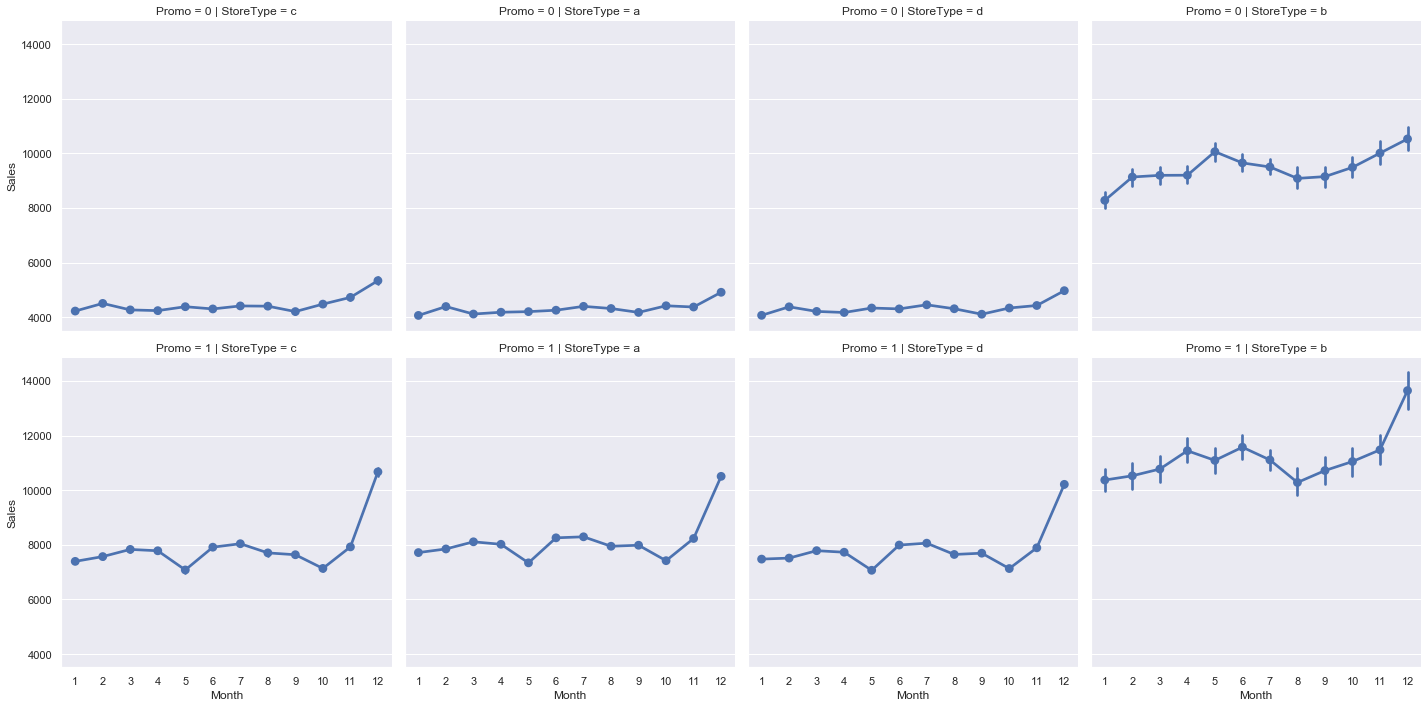

In [138]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType',
#                hue = 'StoreType',
               row = 'Promo',
#                palette = 'plasma',
              )

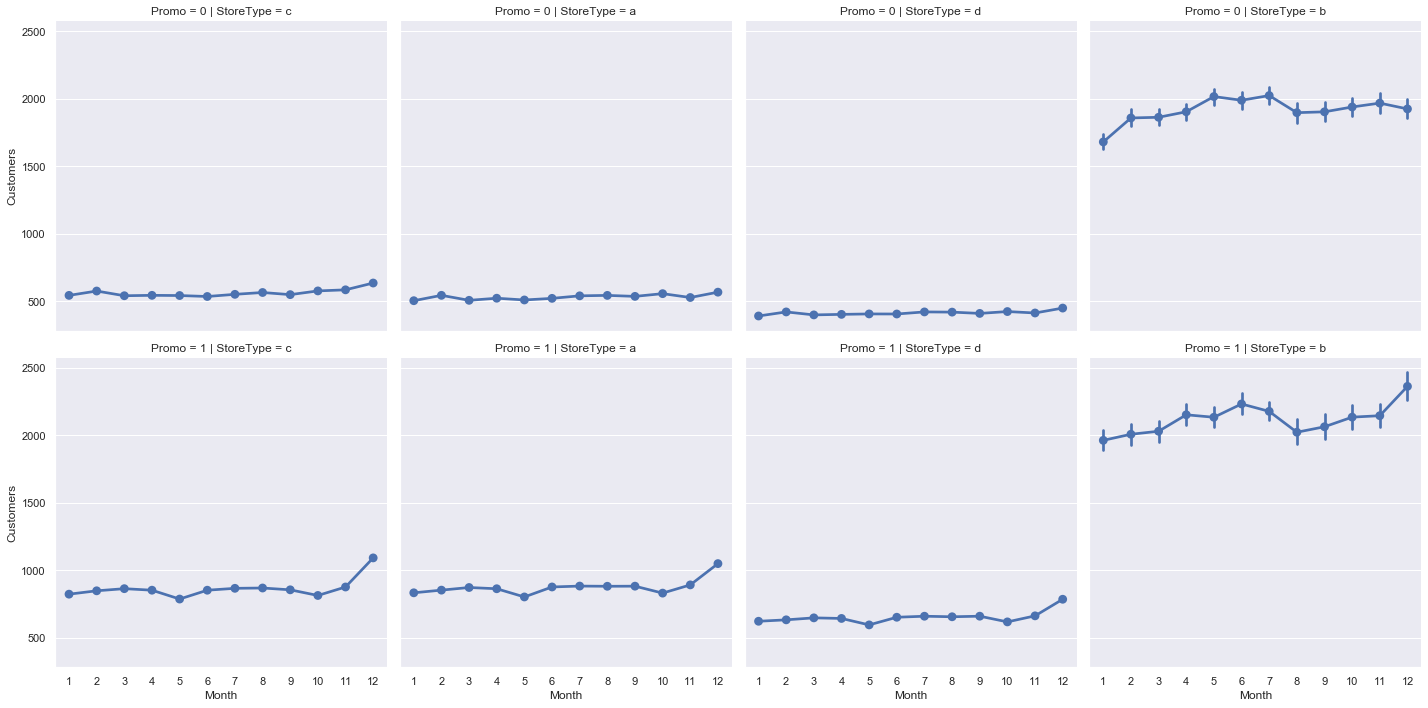

In [140]:
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType',
#                hue = 'StoreType',
               row = 'Promo',
#                palette = 'plasma',
              )

从上面两图可以发现：销售额和客流量与是否促销和类型有很大关系；且在第12个月都有个较大的上涨。猜测是因为`圣诞节`大家都去促销店购物。类型 b 商店的销售额和客流量相比其他类型商店要高很多。

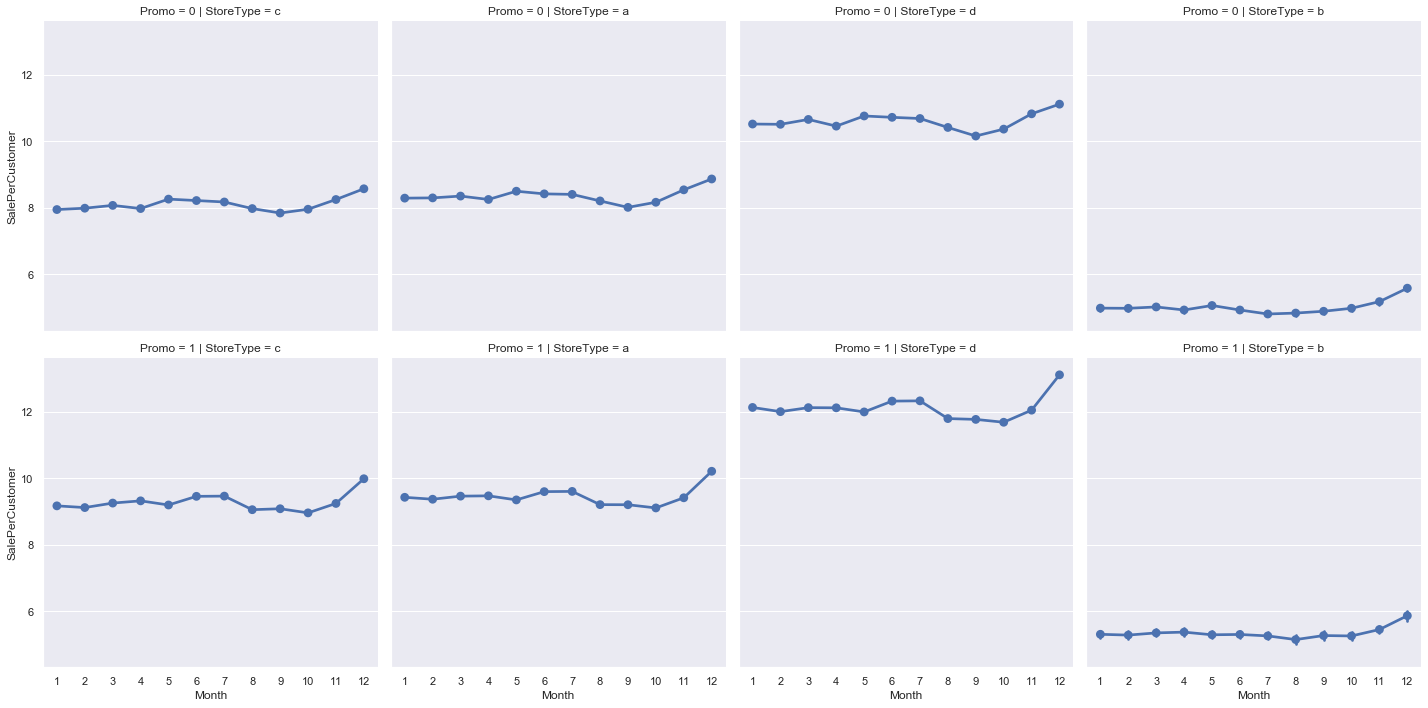

In [144]:
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType',
               row = 'Promo',
              )

可以发现，虽然类型b的商店销售量和顾客量很多，但是人均销售量很少；而类型d销售量和顾客量很少，但是人均销售很高。推翻之前的结论：`StoreType b` 稍微高端。

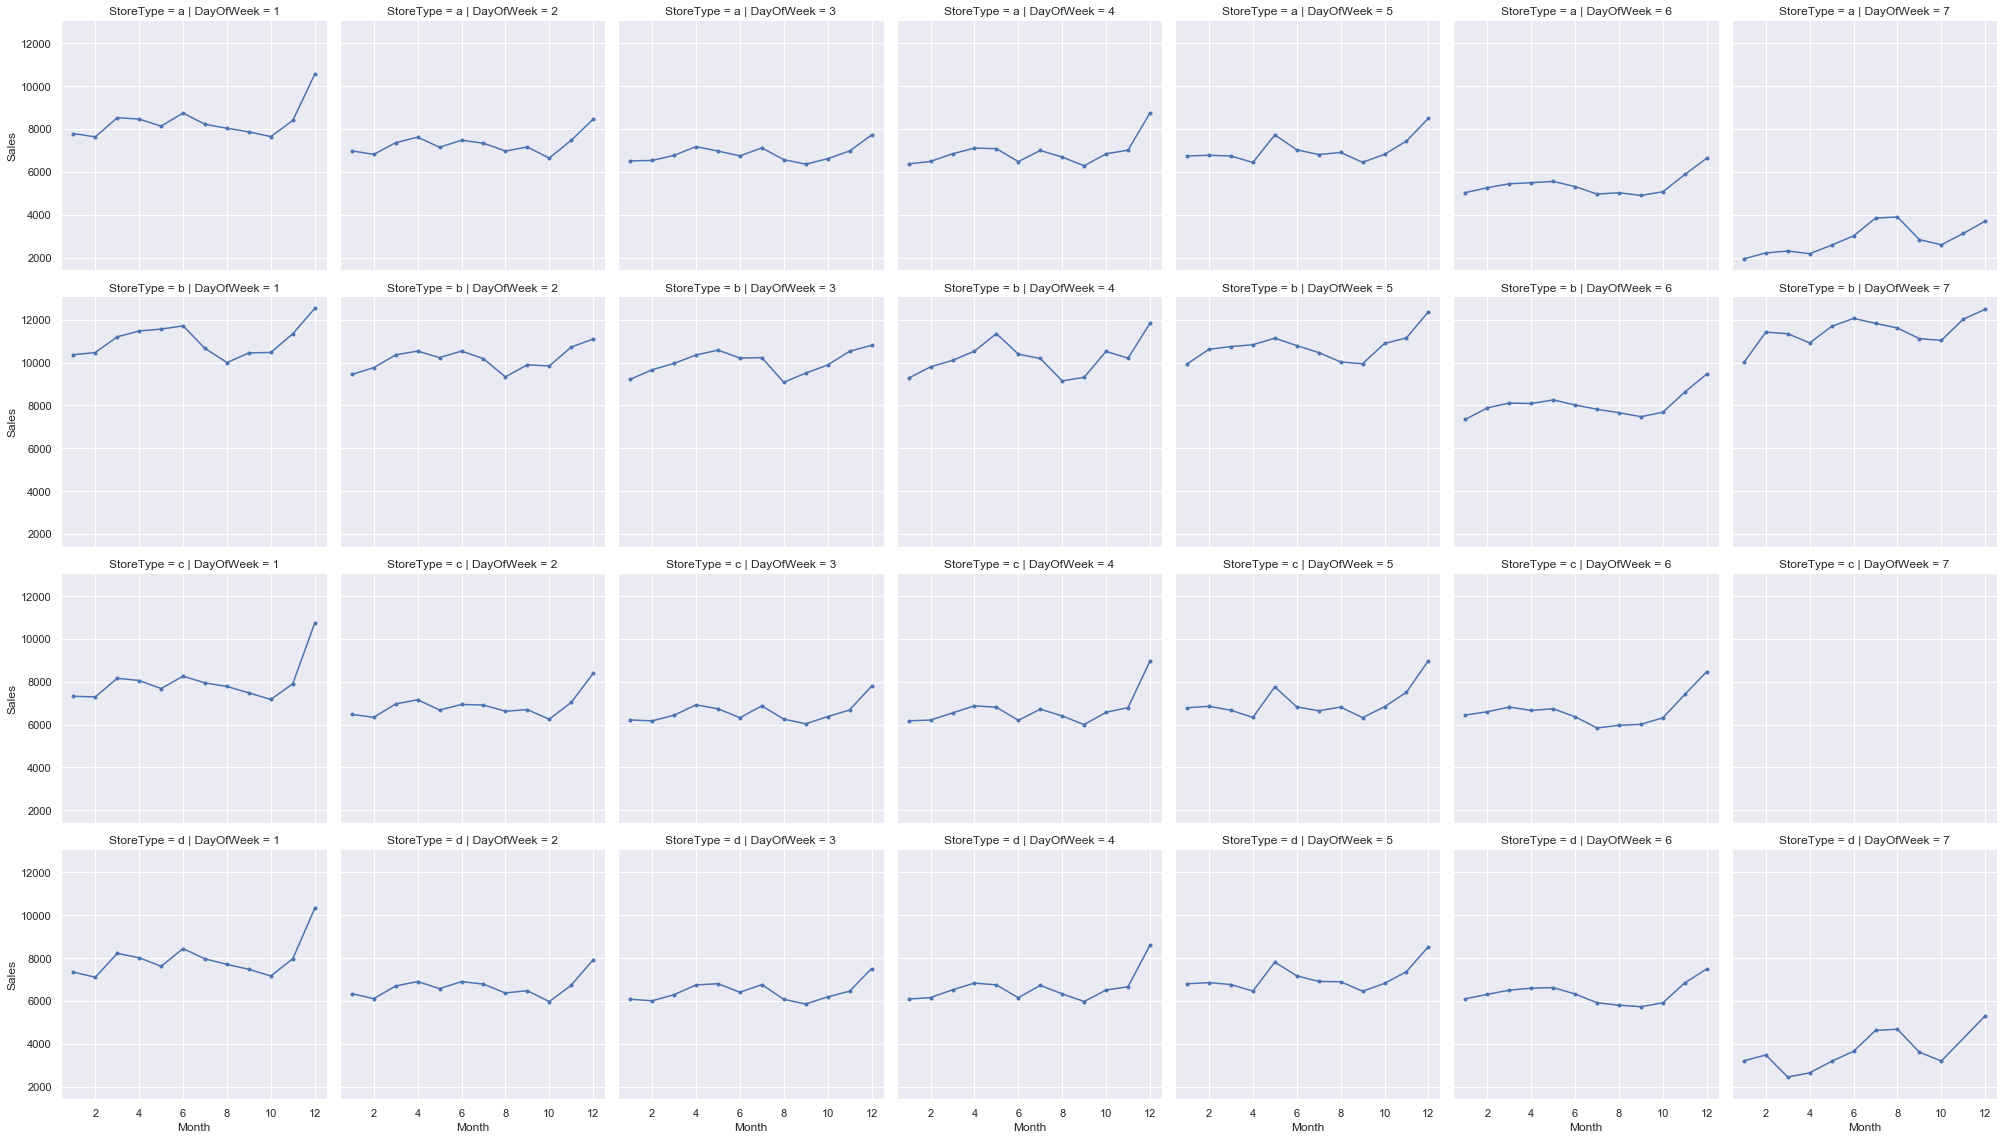

In [207]:
g = sns.FacetGrid(train_store.groupby(['DayOfWeek','StoreType','Month'],as_index=False)['Sales'].mean(), 
                  col="DayOfWeek", row = 'StoreType',height=4)
g.map(plt.plot, "Month", "Sales", marker=".")

类型c周日都关门，且类型d在11月周日关门。

In [157]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877])

In [158]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


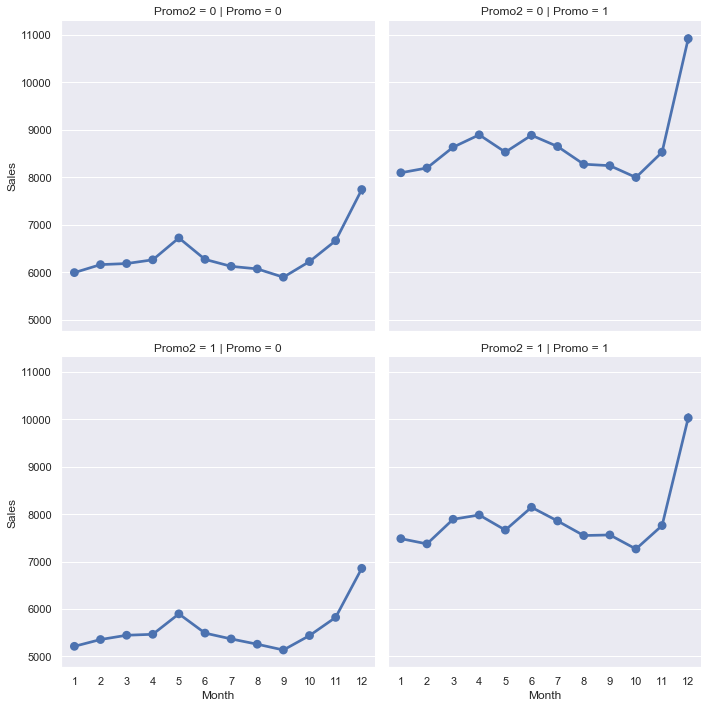

In [208]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo',
#                hue = 'StoreType',
               row = 'Promo2',
#                palette = 'plasma',
              )

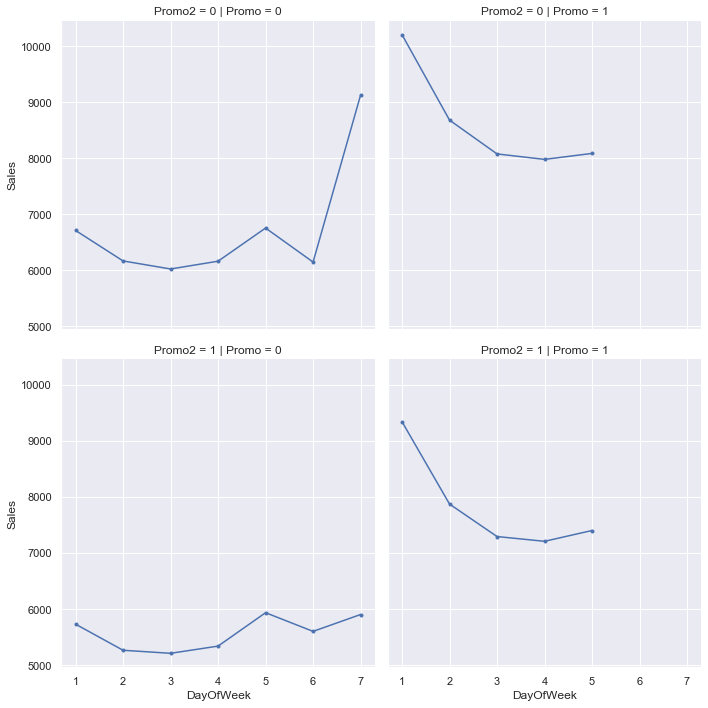

In [209]:
g = sns.FacetGrid(train_store.groupby(['Promo','Promo2','DayOfWeek'],as_index=False)['Sales'].mean(), 
                  col="Promo", row = 'Promo2',height=5)
g.map(plt.plot, "DayOfWeek", "Sales", marker=".")

`Promo` 不发生在周六和周日。`Promo`对销售的影响较大，但是`Promo2`对销售的有负面影响。有`Promo`，销售的峰值发生在周一，无`Promo`，销售的峰值发生在周日。

In [73]:
Assortment = \
    pd.DataFrame(store['Assortment'].value_counts()).sort_index(ascending=False).reset_index()

c = bar(Assortment,'Assortment', "Assortment Distribution")
c.render_notebook()

- [Rossmann Store Sales](https://github.com/datageekette/rossmann_TSA_forecasts/blob/master/Rossmann_Sales.ipynb)
- [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api)